Regression and DNN Model 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pydot

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


Get Dataset

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
#The dataset contains a few unknown values.
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
#Drop those rows to keep this initial tutorial simple.
dataset = dataset.dropna()

In [6]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

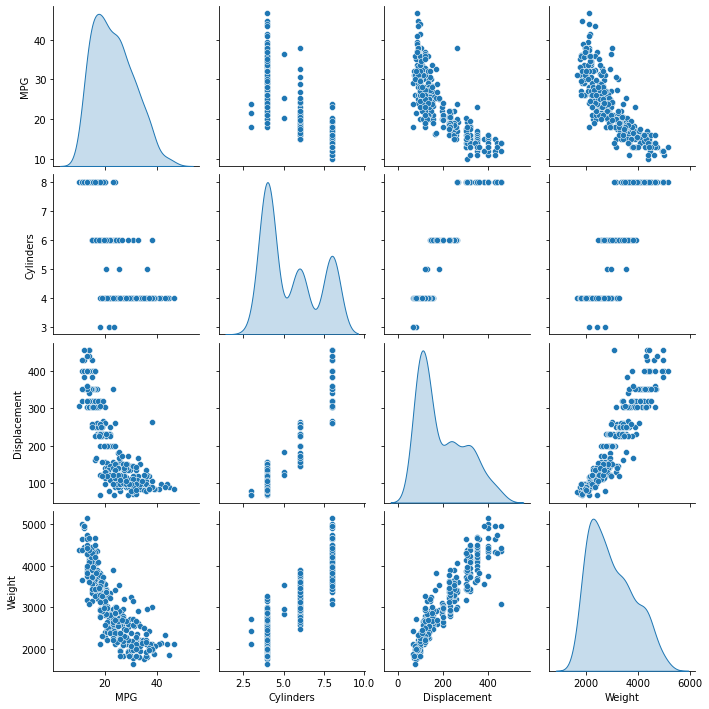

In [8]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [9]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [10]:
#Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
train_labels = train_features.pop('Cylinders')
test_labels = test_features.pop('MPG')
test_labels = test_features.pop('Cylinders')

print(train_labels)

146    4
282    4
69     8
378    4
331    4
      ..
281    6
229    8
150    4
145    4
182    4
Name: Cylinders, Length: 314, dtype: int64


In [11]:
#In the table of statistics it's easy to see how different the ranges of each feature are.
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [12]:
#Normalization

normalizer = preprocessing.Normalization()

normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

print(type(normalizer))


[ 195.318  104.869 2990.252   15.559   75.898    0.178    0.197    0.624]
<class 'tensorflow.python.keras.layers.preprocessing.normalization.Normalization'>


In [13]:
first = np.array(train_features[:1])
tx = np.array(train_features)


with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [14]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

Keras Functional API


In [15]:
def build_and_compile_model(norm):
    inputs = keras.Input(shape=(8,))

    dense = layers.Dense(64, activation="relu")
    x = dense(inputs)

    x = layers.Dense(64, activation="relu")(x)

    output_mph = layers.Dense(1)(x)
    output_cyl = layers.Dense(1)(x)


    model = keras.Model(inputs=inputs, outputs=[output_mph,output_cyl])
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001),metrics=["accuracy"])
    return model

In [16]:
dnn_model = build_and_compile_model(normalizer)

In [17]:
dnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           576         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            65          dense_1[0][0]                    
______________________________________________________________________________________________

In [18]:
%%time
history = dnn_model.fit(train_features, train_labels, batch_size=60, epochs=60, validation_split=0.001)


Epoch 1/60
6/6 [==============================] - 2s 300ms/step - loss: 786.3685 - dense_2_loss: 294.4385 - dense_3_loss: 491.9300 - dense_2_accuracy: 0.0000e+00 - dense_3_accuracy: 0.0000e+00 - val_loss: 193.3799 - val_dense_2_loss: 34.1316 - val_dense_3_loss: 159.2483 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_accuracy: 0.0000e+00
Epoch 2/60
6/6 [==============================] - 0s 21ms/step - loss: 154.0691 - dense_2_loss: 37.4688 - dense_3_loss: 116.6003 - dense_2_accuracy: 0.0000e+00 - dense_3_accuracy: 0.0000e+00 - val_loss: 116.3785 - val_dense_2_loss: 20.1200 - val_dense_3_loss: 96.2585 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_accuracy: 0.0000e+00
Epoch 3/60
6/6 [==============================] - 0s 20ms/step - loss: 151.0537 - dense_2_loss: 21.7329 - dense_3_loss: 129.3208 - dense_2_accuracy: 0.0000e+00 - dense_3_accuracy: 0.0000e+00 - val_loss: 43.3840 - val_dense_2_loss: 7.3357 - val_dense_3_loss: 36.0482 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_accura

None


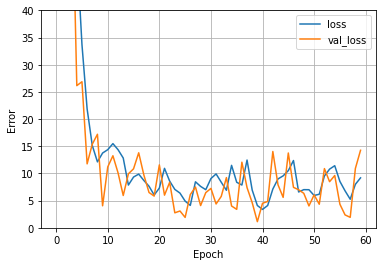

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 40])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
print(plot_loss(history))

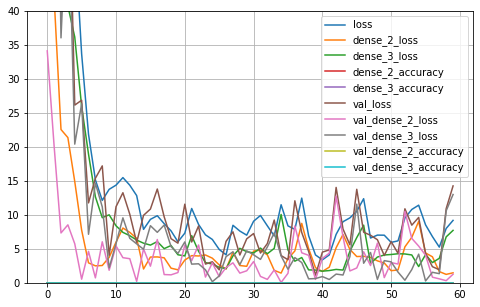

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 40) 
plt.show()

In [20]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

[16.879362106323242, 2.4387359619140625, 14.440627098083496, 0.0, 0.0]

In [21]:
test_predictions = dnn_model.predict()

a = plt.axes(aspect='equal')
plt.scatter(test_labels('MPG'), test_predictions('MPG'))
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


TypeError: predict() missing 1 required positional argument: 'x'